# How To Create Cyclic Cumulant Plot Estimate

![Cyclic Cumulant Plot](cc_plot.png "Cyclic Cumulant Plot")

Hi, I am a Electrical Engineering student who was doing blind modulation recognition using cyclic cumulant as my honours thesis. Although there are some resources on how to calculate cyclic cumulant, the equation for calculating cyclic cumulant is still very scary, and there is still some confusion on how to implement it in code, so I would like to walkthrough my method on how to do it. There might be errors, flaws, etc. so please tell me in the github comments. This is done using Anaconda and Jupyer Notebook.

## Credit

Thank you to the Cyclostationary Blog made by Chad Spooner. It has been a crucial resource for me to understand how to calculate cyclic cumulant. The comments in each blog have been extremely helpful too. 

Thank you to my supervisor Philip Leong for introducing me to Cyclostationary Signal Processing and encouraging me to create this notebook.

## Importing libraries

Make sure you have NumPy and Matplotlib installed on your computer.

In [1]:
import numpy as np
from srrcDesign import srrcDesign
import matplotlib.pyplot as plt

## Table of Contents

- [1 - Generating Digitally Modulated Signals (BPSK, QPSK, 8PSK, 16QAM](#1)
- [2 - Cyclic Moment](#2)
- [3 - Carrier Frequency Offset and Symbol Rate Estimate](#3)
- [4 - Cyclic Cumulant](#4) 
- [5 - Visualizing Cyclic Cumulant](#5)

<a name='1'></a>
## 1. Generating digitally modulated signals (BPSK, QPSK, 8PSK, 16QAM)
Reference: 
- [Building a PSK and QAM Modulator in Python](https://www.wavewalkerdsp.com/2022/06/08/building-a-psk-and-qam-modulator-in-python/) by WaveWalkerDSP

Signal Parameters:

- **Length**: 32768 (The longer the better)
- **Sample Rate**: 1 Hz (Normalized)
- **SNR**: Infinite (No noise)
- **Pulse Shaping Filter**: Square Root Raised Cosine (SRRC)
- **Rolloff factor**: 0.5
- **Carrier Frequency Offset**: 0.01 Hz
- **Symbol Rate**: 0.125 Hz

Skip to the next section if you just want to get started on calculating cyclic cumulant

In [2]:
n = 2**15 # Signal Length
fs = 1 # Sample Rate
beta = 0.5 # Roll off factor
sample_per_symbol = 8 # 1/symbol_rate
filter_span = 21
number_of_symbol = 4096 # n/sample_per_symbol
cfo = 0.01 # Carrier Frequency Offset

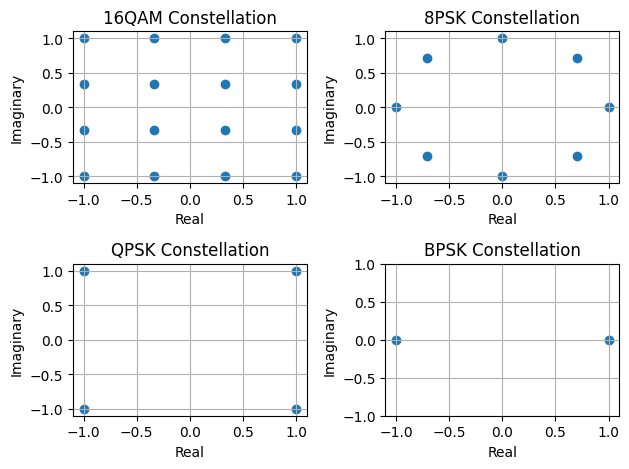

In [3]:
# Create constellation maps

BPSKMap = np.array([-1, 1])
QPSKMap = np.array([-1-1j, -1+1j, 1+1j, 1-1j])
PSKMap = np.exp(1j*2*np.pi*np.arange(0, 8)/8)
QAMMap = np.array([-1-1j, -1/3-1j, 1/3-1j, 1-1j,
                   -1-1/3j, -1/3-1/3j, 1/3-1/3j, 1-1/3j,
                   -1+1/3j, -1/3+1/3j, 1/3+1/3j, 1+1/3j,
                   -1+1j, -1/3+1j, 1/3+1j, 1+1j])

# Plot to check

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.scatter(np.real(QAMMap), np.imag(QAMMap))
ax1.set_title("16QAM Constellation")
ax1.set_ylabel('Imaginary') 
ax1.set_xlabel('Real') 
ax1.set_yticks(np.linspace(-1, 1, num=5))
ax1.set_xticks(np.linspace(-1, 1, num=5))
ax1.grid()         

ax2.scatter(np.real(PSKMap), np.imag(PSKMap))
ax2.set_title("8PSK Constellation")
ax2.set_ylabel('Imaginary') 
ax2.set_xlabel('Real') 
ax2.set_yticks(np.linspace(-1, 1, num=5))
ax2.set_xticks(np.linspace(-1, 1, num=5))
ax2.grid()              

ax3.scatter(np.real(QPSKMap), np.imag(QPSKMap))
ax3.set_title("QPSK Constellation")
ax3.set_ylabel('Imaginary') 
ax3.set_xlabel('Real') 
ax3.set_yticks(np.linspace(-1, 1, num=5))
ax3.set_xticks(np.linspace(-1, 1, num=5))
ax3.grid()              

ax4.scatter(np.real(BPSKMap), np.imag(BPSKMap))
ax4.set_title("BPSK Constellation")
ax4.set_ylabel('Imaginary') 
ax4.set_xlabel('Real') 
ax4.set_yticks(np.linspace(-1, 1, num=5))
ax4.set_xticks(np.linspace(-1, 1, num=5))
ax4.grid()              
fig.tight_layout()

In [4]:
# Generate random sequence of symbol

map_index = np.random.randint(0, len(QAMMap), number_of_symbol) 
QAMSymbols = QAMMap[map_index]

map_index = np.random.randint(0, len(PSKMap), number_of_symbol) 
PSKSymbols = PSKMap[map_index]

map_index = np.random.randint(0, len(QPSKMap), number_of_symbol) 
QPSKSymbols = QPSKMap[map_index]

map_index = np.random.randint(0, len(BPSKMap), number_of_symbol) 
BPSKSymbols = BPSKMap[map_index]

# Upsampling the symbols
QAM_symbols_upsampled = np.zeros(number_of_symbol*sample_per_symbol,dtype=complex)
QAM_symbols_upsampled[::sample_per_symbol] = QAMSymbols

PSK_symbols_upsampled = np.zeros(number_of_symbol*sample_per_symbol,dtype=complex)
PSK_symbols_upsampled[::sample_per_symbol] = PSKSymbols

QPSK_symbols_upsampled = np.zeros(number_of_symbol*sample_per_symbol,dtype=complex)
QPSK_symbols_upsampled[::sample_per_symbol] = QPSKSymbols

BPSK_symbols_upsampled = np.zeros(number_of_symbol*sample_per_symbol,dtype=complex)
BPSK_symbols_upsampled[::sample_per_symbol] = BPSKSymbols

# Filtering through SRRC pulse shaping filter
SRRC_pulse_shape = srrcDesign(sample_per_symbol, filter_span, beta)

QAM_signal = np.convolve(QAM_symbols_upsampled, SRRC_pulse_shape)
PSK_signal = np.convolve(PSK_symbols_upsampled, SRRC_pulse_shape)
QPSK_signal = np.convolve(QPSK_symbols_upsampled, SRRC_pulse_shape)
BPSK_signal = np.convolve(BPSK_symbols_upsampled, SRRC_pulse_shape)

n = len(QAM_signal)

# Add carrier frequency offset
QAM_signal_with_offset = np.exp(1j*2*np.pi*cfo*np.arange(0, n)) * QAM_signal
PSK_signal_with_offset = np.exp(1j*2*np.pi*cfo*np.arange(0, n)) * PSK_signal
QPSK_signal_with_offset = np.exp(1j*2*np.pi*cfo*np.arange(0, n)) * QPSK_signal
BPSK_signal_with_offset = np.exp(1j*2*np.pi*cfo*np.arange(0, n)) * BPSK_signal

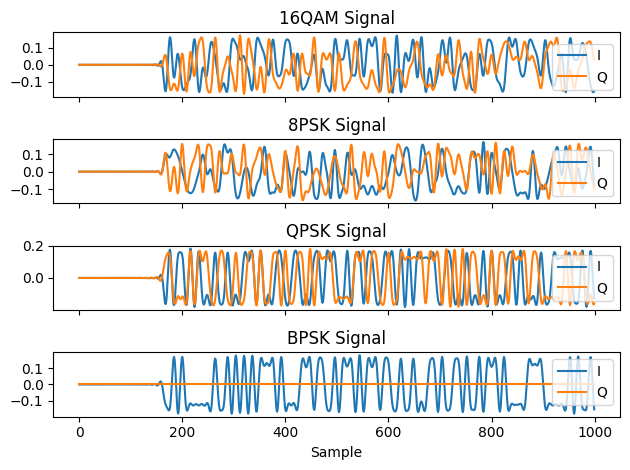

In [5]:
# Plot the signal to check
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
ax1.plot(np.real(QAM_signal[0:1000]))
ax1.plot(np.imag(QAM_signal[0:1000]))
ax1.set_title("16QAM Signal")
ax1.legend(["I", "Q"])

ax2.plot(np.real(PSK_signal[0:1000]))
ax2.plot(np.imag(PSK_signal[0:1000]))
ax2.set_title("8PSK Signal") 
ax2.legend(["I", "Q"])

ax3.plot(np.real(QPSK_signal[0:1000]))
ax3.plot(np.imag(QPSK_signal[0:1000]))
ax3.set_title("QPSK Signal") 
ax3.legend(["I", "Q"])

ax4.plot(np.real(BPSK_signal[0:1000]))
ax4.plot(np.imag(BPSK_signal[0:1000]))
ax4.set_xlabel("Sample")
ax4.set_title("BPSK Signal") 
ax4.legend(["I", "Q"])

     
fig.tight_layout()

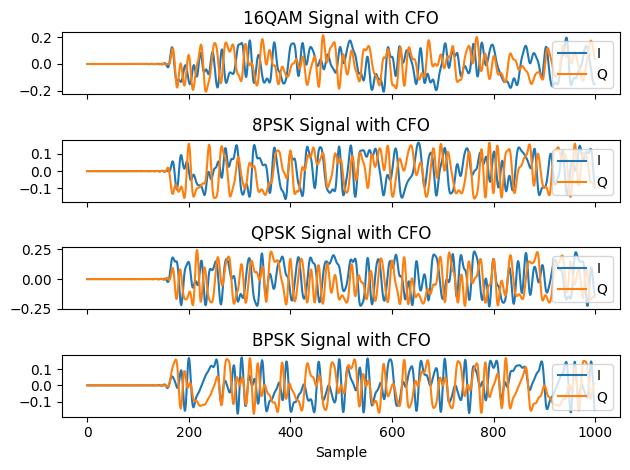

In [6]:
# Plot the signal to check
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
ax1.plot(np.real(QAM_signal_with_offset[0:1000]))
ax1.plot(np.imag(QAM_signal_with_offset[0:1000]))
ax1.set_title("16QAM Signal with CFO")
ax1.legend(["I", "Q"])

ax2.plot(np.real(PSK_signal_with_offset[0:1000]))
ax2.plot(np.imag(PSK_signal_with_offset[0:1000]))
ax2.set_title("8PSK Signal with CFO") 
ax2.legend(["I", "Q"])

ax3.plot(np.real(QPSK_signal_with_offset[0:1000]))
ax3.plot(np.imag(QPSK_signal_with_offset[0:1000]))
ax3.set_title("QPSK Signal with CFO") 
ax3.legend(["I", "Q"])

ax4.plot(np.real(BPSK_signal_with_offset[0:1000]))
ax4.plot(np.imag(BPSK_signal_with_offset[0:1000]))
ax4.set_xlabel("Sample")
ax4.set_title("BPSK Signal with CFO") 
ax4.legend(["I", "Q"])

     
fig.tight_layout()

<a name='2'></a>
## 2. Cyclic Moment

For a more rigorous explaination:
- [Cyclic Temporal Cumulants](https://cyclostationary.blog/2016/02/14/cyclic-temporal-cumulants/) by CSPBlog

Communication signals are modeled as random process with cyclostationary property. 
We are going to use Fraction of Time (FOT) Framework and its Sine Wave Extractor $E^{\alpha}$ which is built on single time sequence data, replacing the expectation operator $E$. The FOT framework simply defines cyclostationary as the property of a signal that generates a periodic component after undergoing a nonlinear operation. An example is shown below.

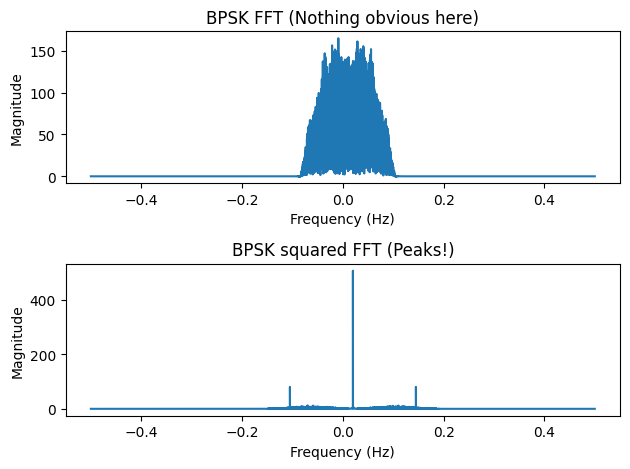

In [7]:
# Apply non linear operation on signal (power of 2, element-wise)

pow_2_signal = BPSK_signal_with_offset ** 2

f = fs/n * np.arange(-n/2, n/2)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(f, np.abs(np.fft.fftshift(np.fft.fft(BPSK_signal_with_offset))))
ax1.set_title("BPSK FFT (Nothing obvious here)")
ax1.set_ylabel('Magnitude') 
ax1.set_xlabel('Frequency (Hz)') 

ax2.plot(f, np.abs(np.fft.fftshift(np.fft.fft(pow_2_signal))))
ax2.set_title("BPSK squared FFT (Peaks!)")
ax2.set_ylabel('Magnitude') 
ax2.set_xlabel('Frequency (Hz)') 

fig.tight_layout()

The nonlinear operation that is regularly used is a statistical measure called moment. 

$R(t, \bar{\tau}, n, m, \bar{b}) = E^{\alpha} \left[ \prod_{j=1}^{n} s^{(*)_j}(t - \tau_j) \right]$

where:
- s(t) is the signal
- $\bar{\tau}$ is the delay vector. Each element, $\tau_j$ correspond to a delay in the signal s(t)
- n is the order
- m is the number of conjugation
- $\bar{b}$ is a binary vector to indicate which signal is conjugated

We will set all delay to 0.

$R(t, \bar{0}, n, m, \bar{b}) = E^{\alpha} \left[ \prod_{j=1}^{n} s^{(*)_j}(t) \right]$

$E^{\alpha}$ operator remove any noise from the signal. This can be done using synchronized averaging (CSPBlog [Cyclic Cumulant Estimator](https://cyclostationary.blog/2017/09/11/csp-estimators-cyclic-temporal-moments-and-cumulants/)) but we are going to skip it because our signals have no noise.

The moment equation with delay 0 is basically multiplying the signal by itself n amount of time and applying m conjugation to the signal while multiplying. For example, $R(t, \bar{0}, 2, 1, \bar{b}) = E^{\alpha} \left[ \prod_{j=1}^{2} s^{(*)_j}(t) \right]$ would be $s(t) * conj(s(t))$ given there is no noise in s(t).

The moment contains periodic components that can be expressed as a Fourier series:

$R(t, \bar{\tau}, n, m, \bar{b}) = \sum_{\alpha}R^{\alpha}(\bar{\tau}, n, m,  \bar{b})e^{j2\pi\alpha t}$

The Fourier Coefficients of the moment are called cyclic moment. They can be found by

$R^{\alpha}(\bar{\tau}, n, m, \bar{b}) = \sum_{t}R(t, \bar{\tau}, n, m,  \bar{b})e^{-j2\pi\alpha t}$

Looking at the FFT plot, we can also see the Cyclic Moments. They are the peaks that are generated after the nonlinear operation. For example, let's look at R(t, 0, 2, 1): Second order moment, one conjugation.

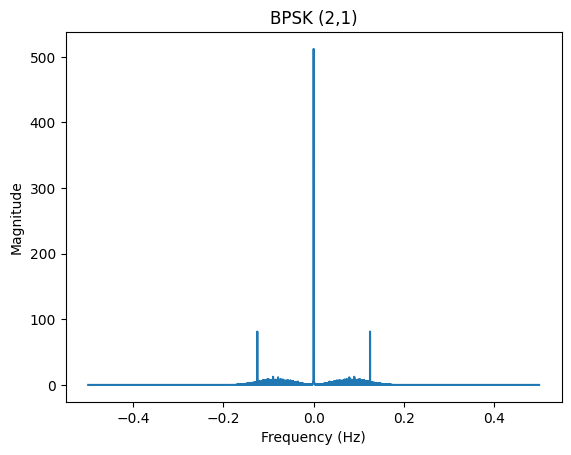

In [8]:
plt.plot(f, np.abs(np.fft.fftshift(np.fft.fft(BPSK_signal_with_offset * np.conj(BPSK_signal_with_offset)))))
plt.title("BPSK (2,1)")
plt.ylabel('Magnitude') 
plt.xlabel('Frequency (Hz)') 
plt.show()

<a name='3'></a>
## 3. Carrier Frequency Offset and Symbol Rate Estimate

Reference:
- [Simple Synchronisation](https://cyclostationary.blog/2019/04/26/simple-synchronization-using-csp/) by CSPBlog

The frequency $\alpha$ where the cyclic moment peak occur relates back to some important parameters of the signal. Those are the carrier frequency offset $f_o$, symbol rate $f_{sym}$, order n and conjugation m.

$\alpha = (n-2m)f_0 + k f_{sym}$

where k = ..., -2, -1, 0, 1, 2... or until we hit the aliasing limit $\pm f_s/2$. Note, this equation applies for **most but not all** communication signals. Some exceptions are MSK and $\pi/4-DQPSK$

Knowing this, we can estimate the signal parameters using the location of the cyclic moment peaks.

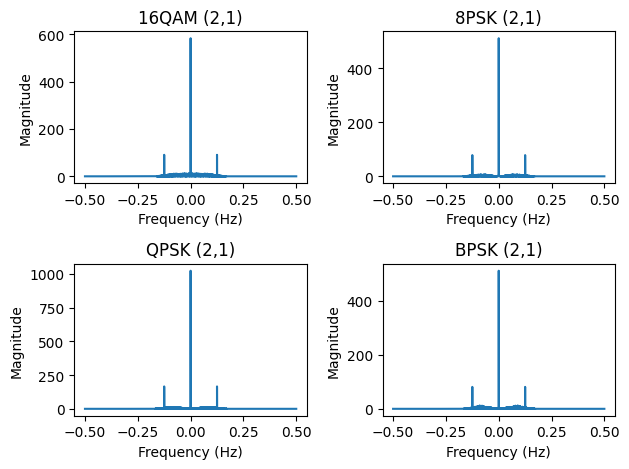

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(f, np.abs(np.fft.fftshift(np.fft.fft(QAM_signal_with_offset * np.conj(QAM_signal_with_offset)))))
ax1.set_title("16QAM (2,1)")
ax1.set_ylabel('Magnitude') 
ax1.set_xlabel('Frequency (Hz)')        

ax2.plot(f, np.abs(np.fft.fftshift(np.fft.fft(PSK_signal_with_offset * np.conj(PSK_signal_with_offset)))))
ax2.set_title("8PSK (2,1)")
ax2.set_ylabel('Magnitude') 
ax2.set_xlabel('Frequency (Hz)')          

ax3.plot(f, np.abs(np.fft.fftshift(np.fft.fft(QPSK_signal_with_offset * np.conj(QPSK_signal_with_offset)))))
ax3.set_title("QPSK (2,1)")
ax3.set_ylabel('Magnitude') 
ax3.set_xlabel('Frequency (Hz)') 

ax4.plot(f, np.abs(np.fft.fftshift(np.fft.fft(BPSK_signal_with_offset * np.conj(BPSK_signal_with_offset)))))
ax4.set_title("BPSK (2,1)")
ax4.set_ylabel('Magnitude') 
ax4.set_xlabel('Frequency (Hz)')            
fig.tight_layout()

We'll use second order, one conjugation moment (n = 2, m = 1) to estimate the symbol rate (Can you guess why?). The cyclic peaks occur at $\pm f_{sym}$ which is 0.125 Hz. To confirm this, we'll find the frequency where the peak occur by sorting the magnitude and finding the frequency of the second largest peak.

In [10]:
qam_fft = np.abs(np.fft.fftshift(np.fft.fft(QAM_signal_with_offset * np.conj(QAM_signal_with_offset))))

sorted_indeces = np.flip(np.argsort(qam_fft)) # Flip from ascending to descending

print("16QAM (2,1) second largest peak occur at: ", f[sorted_indeces[1]])

symbol_rate = np.abs(f[sorted_indeces[1]])

16QAM (2,1) second largest peak occur at:  0.125


To estimate the CFO, we will use fourth order moment, no conjugation. The resulting peaks will occur at $\alpha = 4f_o \pm k f_{sym}$. We can also confirm this by extracting the frequency of the peaks (k = 0, $\pm1$).

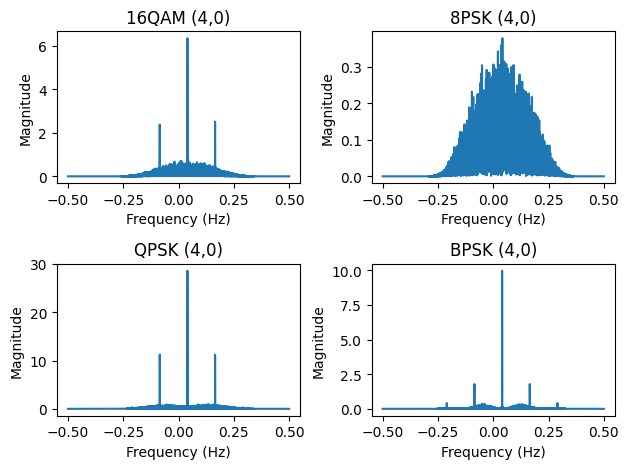

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(f, np.abs(np.fft.fftshift(np.fft.fft(QAM_signal_with_offset**4))))
ax1.set_title("16QAM (4,0)")
ax1.set_ylabel('Magnitude') 
ax1.set_xlabel('Frequency (Hz)')        

ax2.plot(f, np.abs(np.fft.fftshift(np.fft.fft(PSK_signal_with_offset**4))))
ax2.set_title("8PSK (4,0)")
ax2.set_ylabel('Magnitude') 
ax2.set_xlabel('Frequency (Hz)')          

ax3.plot(f, np.abs(np.fft.fftshift(np.fft.fft(QPSK_signal_with_offset**4))))
ax3.set_title("QPSK (4,0)")
ax3.set_ylabel('Magnitude') 
ax3.set_xlabel('Frequency (Hz)') 

ax4.plot(f, np.abs(np.fft.fftshift(np.fft.fft(BPSK_signal_with_offset**4))))
ax4.set_title("BPSK (4,0)")
ax4.set_ylabel('Magnitude') 
ax4.set_xlabel('Frequency (Hz)')            
fig.tight_layout()

In [12]:
# This is pretty rudimentary way of finding peaks. A peak finder function would be better.

qam_fft = np.abs(np.fft.fftshift(np.fft.fft(QAM_signal_with_offset**4)))
sorted_indeces = np.flip(np.argsort(qam_fft)) # Flip from ascending to descending
print("16QAM (4, 0) largest peak occurs at: ", f[sorted_indeces[0]])
print("16QAM (4, 0) second largest peak occurs at: ", f[sorted_indeces[1]])
print("16QAM (4, 0) third largest peak occurs at: ", f[sorted_indeces[2]])

# Take the highest peak location and divide by 4 to get CFO
qam_cfo = f[sorted_indeces[0]]/4
print("CFO of 16 QAM is: ", qam_cfo)

16QAM (4, 0) largest peak occurs at:  0.03999516674722088
16QAM (4, 0) second largest peak occurs at:  0.16499516674722087
16QAM (4, 0) third largest peak occurs at:  -0.08500483325277912
CFO of 16 QAM is:  0.00999879168680522


In [13]:
qpsk_fft = np.abs(np.fft.fftshift(np.fft.fft(QPSK_signal_with_offset**4)))
sorted_indeces = np.flip(np.argsort(qpsk_fft)) # Flip from ascending to descending
print("QPSK (4, 0) largest peak occurs at: ", f[sorted_indeces[0]])
print("QPSK (4, 0) second largest peak occurs at: ", f[sorted_indeces[1]])
print("QPSK (4, 0) third largest peak occurs at: ", f[sorted_indeces[2]])

# Take the highest peak location and divide by 4 to get CFO
qpsk_cfo = f[sorted_indeces[0]]/4
print("CFO of QPSK is: ", qpsk_cfo)

QPSK (4, 0) largest peak occurs at:  0.03999516674722088
QPSK (4, 0) second largest peak occurs at:  -0.08500483325277912
QPSK (4, 0) third largest peak occurs at:  0.16499516674722087
CFO of QPSK is:  0.00999879168680522


In [14]:
bpsk_fft = np.abs(np.fft.fftshift(np.fft.fft(BPSK_signal_with_offset**4)))
sorted_indeces = np.flip(np.argsort(bpsk_fft)) # Flip from ascending to descending
print("BPSK (4, 0) largest peak occurs at: ", f[sorted_indeces[0]])
print("BPSK (4, 0) second largest peak occurs at: ", f[sorted_indeces[2]])
print("BPSK (4, 0) third largest peak occurs at: ", f[sorted_indeces[3]])

# Take the highest peak location and divide by 4 to get CFO
bpsk_cfo = f[sorted_indeces[0]]/4
print("CFO of BPSK is: ", bpsk_cfo)

BPSK (4, 0) largest peak occurs at:  0.03999516674722088
BPSK (4, 0) second largest peak occurs at:  0.16499516674722087
BPSK (4, 0) third largest peak occurs at:  -0.08500483325277912
CFO of BPSK is:  0.00999879168680522


As we can see, the peaks showed up at the expected frequency:
- One at k = 0 which is $\alpha = 4*f_o = 0.04$
- One at k = -1 which is $\alpha = 4*f_o - f_{sym} = 0.04 - 0.125 = -0.085$
- One at k = 1 which is $\alpha = 4*f_o + f_{sym} = 0.04 + 0.125 = 0.165$

To estimate the CFO for BPSK, 16QAM and QPSK, we just need to find the highest peak and divide the frequency of the peak by 4. Here it would be 0.04/4 = 0.01 Hz.

But for 8PSK there is no such peaks. It has no 4th order cyclic moments. This is okay as this is what distinguish the modulation types from each other. Some have peaks in certain order and conjugation. Some don't.

To estimate the CFO for 8PSK, we need to bring it up to 8th order moment.

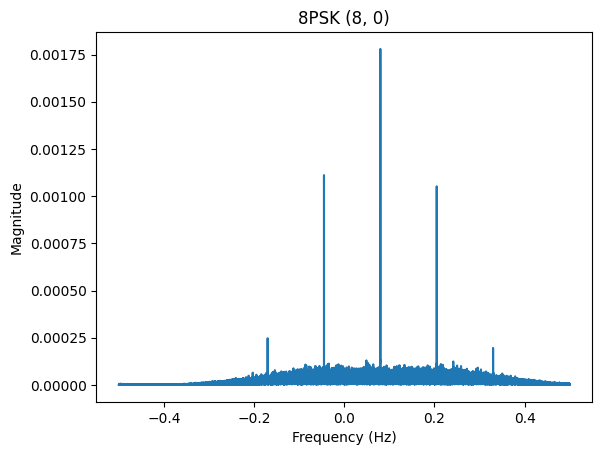

In [15]:
plt.plot(f, np.abs(np.fft.fftshift(np.fft.fft(PSK_signal_with_offset**8))))
plt.title("8PSK (8, 0)")
plt.ylabel('Magnitude') 
plt.xlabel('Frequency (Hz)')
plt.show()

In [16]:
psk_fft = np.abs(np.fft.fftshift(np.fft.fft(PSK_signal_with_offset**8)))
sorted_indeces = np.flip(np.argsort(psk_fft)) # Flip from ascending to descending
print("8PSK (8, 0) largest peak occurs at: ", f[sorted_indeces[0]])

psk_cfo = f[sorted_indeces[0]]/8
print("CFO of BPSK is: ", psk_cfo)

8PSK (8, 0) largest peak occurs at:  0.07999033349444176
CFO of BPSK is:  0.00999879168680522


Just get the frequency of the largest peak and divide by 8, and we will get the CFO. However, this method is not very robust (without synchronized averaging) in present of noise as it will bury the cyclic moment peak. Notice how small the magnitude are for these peak. Compare this to our previous cyclic moment peaks for BPSK, QPSK and 16QAM. 

<a name='4'></a>
## 4. Cyclic Cumulant

After getting the carrier frequency offset and symbol rate, we can automate the peak extraction using the $\alpha = (n-2m)f_0 + k f_{sym}$ equation.

In [42]:
def extract_cyclic_moment_peaks(cfo, symbol_rate, order, conjugation, signal):
    k = np.array([-3, -2, -1, 0, 1, 2, 3])
    # Get the peaks location
    peak_locs = (order - 2*conjugation)*cfo + k*symbol_rate

    # Normalize signal power. This is actually important for generating the final Cyclic Cumulant Plot.
    rms_signal = np.sqrt(np.mean(signal**2))
    signal = signal/rms_signal

    # Do the FFT
    n = len(signal)
    fs = 1
    f = fs/n * np.arange(-n/2, n/2)
    fft_signal = 1/n * np.fft.fftshift(np.fft.fft(signal**(order-conjugation) * np.conj(signal)**conjugation))

    # Extract the cyclic moments magnitude
    peak_locs_vert = peak_locs.reshape(len(k),1)
    # Find the index of the frequency that is closest to the peak location as that is where cyclic moment peak occur
    f_diff = np.abs(f - peak_locs_vert)
    min_indeces = np.argsort(f_diff)
    
    cyclic_moments = fft_signal[min_indeces[:,0]]
    return cyclic_moments

Now that we can extract the cyclic moments, let's move on to calculating the cyclic cumulant. The equation for calculating cyclic cumulant from cyclic moment is:

$C^{\alpha}(\bar{0}, n, m) = \sum_{P}[(-1)^{p-1}(p-1)! \sum_{\bar{\beta}^T\bar{1}=\alpha}\prod_{j=1}^{p}R^{\beta}_j(\bar{0}, n_j, m_j)]$

It looks quite complicated so let's break it down.

$c = \sum_{\bar{\beta}^T\bar{1}=\alpha}\prod_{j=1}^{p}R^{\beta}_j(\bar{0}, n_j, m_j)$

This is simply saying find the combination of cyclic moments that when multiply together, their frequencies sum up to our current cyclic cumulant frequency.

For example, if we are finding 4th order cyclic cumulant with no conjugation (n = 4, m = 0). Our current cyclic frequency $\alpha$ would be 

$\alpha = 4f_o + k f_{sym}$. 

So how do we combine the cyclic moments to get this frequency.

One option is just the fourth order moment itself

$\alpha = 4f_o + k f_{sym}$

$\beta = 4f_o + k f_{sym}$ 

The second option is multiplying 2 second order cyclic moment together to sum up their frequencies

$\alpha = 4f_o + k f_{sym}$

$\beta = 2f_o + k_1 f_{sym}$

$\beta = 2f_o + k_2 f_{sym}$

We know that when summing, the carrier frequency offset side will be the same but how about on the symbol rate side? There will be many combinations of $k_1$ and $k_2$ that adds up to $k$. How do we quickly find the final magnitude at each position $k$?

Let's use an array to store the cyclic moment magnitudes at each $k_1$ and $k_2$ position. We will hightlight the position by showing it in the array.

$k_1: [-2, -1, 0, 1, 2]$

$k_2: [-2, -1, 0, 1, 2]$

If we flip $k_2$ around, we can find all the combination that makes up k.

All combinations of k = 0

$k_1: [-2, -1, 0, +1, +2]$

$k_2: [+2, +1, 0, -1, -2]$

All combination of k = -1 by shifting array by 1 position

$k_1:.....[-2, -1, 0, +1, +2]$

$k_2: [+2, +1, 0, -1, -2]$

All combination of k = -2 by shifting array by 2 position

$k_1:........[-2, -1, 0, +1, +2]$

$k_2: [+2, +1, 0, -1, -2]$

And we just need to multiply the magnitudes at the overlapping position and sum them together.

Long story short, this is just **convolution!**.

So the combinations are $R^{\beta}(\bar{0}, 4, 0)$ and $R^{\beta}(\bar{0}, 2, 0) * R^{\beta}(\bar{0}, 2, 0)$ where $*$ indicates convolution.

Now let's bring in the rest of the equation

$C^{\alpha}(\bar{0}, n, m) = \sum_{P}[(-1)^{p-1}(p-1)! \sum_{\bar{\beta}^T\bar{1}=\alpha}\prod_{j=1}^{p}R^{\beta}_j(\bar{0}, n_j, m_j)]$

The second part relates to the number of combinations of the moment.

If we labeled each signal in our example of finding the 4th order cyclic cumulant using an index from 1, 2, 3, 4, there are many ways to combine them to create the 2nd order moments that add up to cycle frequency $\alpha$ when multiplied together. For example:

\begin{align*}
S_1 &= \{1, 2, 3, 4\} (p = 1) \\
S_2 &= \{\{1, 2\}, \{3, 4\}\} (p = 2) \\
S_3 &= \{\{1, 3\}, \{2, 4\}\} (p = 2) \\
S_4 &= \{\{1, 4\}, \{2, 3\}\} (p = 2) \\
P &= \{S_1, S_2, S_3, S_4\}
\end{align*}

where S is a partition of the signals, p is the number of sets in the the partition S, and if the signals are in a set, they are multiplied together to form the cyclic moment we wanted above. Putting all of this back to our formula, the result will be:

\begin{align*}
C^{\alpha}(\bar{0}, 4, 0) =& (-1)^{(1)-1}((1) - 1)! \times R_{1,2,3,4}^{\alpha}(\bar{0}, 4, 0) \\
 +& (-1)^{(2)-1}((2) - 1)! \times (R_{1,2}^{\beta}(\bar{0}, 2, 0) * R_{3,4}^{\beta}(\bar{0}, 2, 0) \\
 +& (-1)^{(2)-1}((2) - 1)! \times (R_{1,3}^{\beta}(\bar{0}, 2, 0) * R_{2,4}^{\beta}(\bar{0}, 2, 0) \\
 +& (-1)^{(2)-1}((2) - 1)! \times (R_{1,4}^{\beta}(\bar{0}, 2, 0) * R_{2,3}^{\beta}(\bar{0}, 2, 0) \\
 =& R_{1,2,3,4}^{\alpha}(\bar{0}, 4, 0) - 3(R^{\beta}(\bar{0}, 2, 0) * R^{\beta}(\bar{0}, 2, 0)) \\
\end{align*}

If you look at the final result, we are just subtracting the product of lower order cyclic moments from the higher order cyclic moments. This is to make sure the periodic components in high order moment are not just the trivial product of periodic components formed in the lower order moments. By subtracting the product of lower order moment, we ensure that the nonlinearity has created new, non trivial periodic components which will show up in the cyclic cumulant. (Please also check out [Cyclic Temporal Cumulants](https://cyclostationary.blog/2016/02/14/cyclic-temporal-cumulants/)  by CSPBlog. The blog also explaines it very well)

Let's put it into action. First, let's find the second order cyclic cumulant. The good thing is the second order cyclic moments are also the second order cyclic cumulant. This is because there is no periodic components in the first order moment so there is no product of first order moment that we need to subtract off.

In [20]:
cc_2_0_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 2, 0, BPSK_signal_with_offset)
cc_2_1_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 2, 1, BPSK_signal_with_offset)
cc_2_2_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 2, 2, BPSK_signal_with_offset)
print(np.abs(cc_2_0_bpsk))

[2.99703186e-04 4.94191575e-04 8.04165578e+01 5.06737244e+02
 8.04315986e+01 4.93895670e-04 2.99642094e-04]


For the 4th order cyclic cumulants, we need the previous second order cyclic moments and fourth order cyclic moments.

In [21]:
cm_4_0_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 4, 0, BPSK_signal_with_offset)
cm_4_1_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 4, 1, BPSK_signal_with_offset)
cm_4_2_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 4, 2, BPSK_signal_with_offset)
cm_4_3_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 4, 3, BPSK_signal_with_offset)
cm_4_4_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 4, 4, BPSK_signal_with_offset)

cc_4_0_bpsk = cm_4_0_bpsk - 3*np.convolve(cc_2_0_bpsk, cc_2_0_bpsk, 'same')
cc_4_1_bpsk = cm_4_1_bpsk - 3*np.convolve(cc_2_1_bpsk, cc_2_0_bpsk, 'same')
cc_4_2_bpsk = cm_4_2_bpsk - 2*np.convolve(cc_2_1_bpsk, cc_2_1_bpsk, 'same') - np.convolve(cc_2_0_bpsk, cc_2_2_bpsk, 'same')
cc_4_3_bpsk = cm_4_3_bpsk - 3*np.convolve(cc_2_1_bpsk, cc_2_2_bpsk, 'same')
cc_4_4_bpsk = cm_4_4_bpsk - 3*np.convolve(cc_2_2_bpsk, cc_2_2_bpsk, 'same')

4th order, 2 conjugations cyclic cumulant is a little different as there is another combination of $R^{\beta}(\bar{0}, 2, 2) * R^{\beta}(\bar{0}, 2, 0)$ that has frequencies adding up to our target frequencies. $1^*$ means signal 1 is conjugated.
\begin{align*}
C^{\alpha}(\bar{0}, 4, 2) =& (-1)^{(1)-1}((1) - 1)! \times R_{1^*,2^*,3,4}^{\alpha}(\bar{0}, 4, 2) \\
 +& (-1)^{(2)-1}((2) - 1)! \times (R_{1^*,2^*}^{\beta}(\bar{0}, 2, 2) * R_{3,4}^{\beta}(\bar{0}, 2, 0)) \\
 +& (-1)^{(2)-1}((2) - 1)! \times (R_{1^*,3}^{\beta}(\bar{0}, 2, 1) * R_{2^*,4}^{\beta}(\bar{0}, 2, 1)) \\
 +& (-1)^{(2)-1}((2) - 1)! \times (R_{1^*,4}^{\beta}(\bar{0}, 2, 1) * R_{2^*,3}^{\beta}(\bar{0}, 2, 1)) \\
 =& R_{1^*,2^*,3,4}^{\alpha}(\bar{0}, 4, 2) - (R^{\beta}(\bar{0}, 2, 2) * R^{\beta}(\bar{0}, 2, 0))\\
 -& 2(R^{\beta}(\bar{0}, 2, 1) * R^{\beta}(\bar{0}, 2, 1))\\
\end{align*}

It gets more complicated as you go up to higher order. We will go up to the 6th order cyclic cumulant as the limit.

In [22]:
cm_6_0_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 0, BPSK_signal_with_offset)
cm_6_1_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 1, BPSK_signal_with_offset)
cm_6_2_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 2, BPSK_signal_with_offset)
cm_6_3_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 3, BPSK_signal_with_offset)
cm_6_4_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 4, BPSK_signal_with_offset)
cm_6_5_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 5, BPSK_signal_with_offset)
cm_6_6_bpsk = extract_cyclic_moment_peaks(bpsk_cfo, symbol_rate, 6, 6, BPSK_signal_with_offset)

conv_2_bpsk = np.convolve(cc_2_0_bpsk, cc_2_0_bpsk, "same")
cc_6_0_bpsk = cm_6_0_bpsk - 15*np.convolve(cc_2_0_bpsk, cm_4_0_bpsk, "same") + 2*15*np.convolve(conv_2_bpsk, cc_2_0_bpsk, "same")
cc_6_1_bpsk = cm_6_1_bpsk - 5*np.convolve(cc_2_1_bpsk, cm_4_0_bpsk, "same") - 10*np.convolve(cc_2_0_bpsk, cm_4_1_bpsk, "same") \
                + 2*15*np.convolve(conv_2_bpsk, cc_2_1_bpsk, "same")

conv_2_1_bpsk = np.convolve(cc_2_0_bpsk, cc_2_1_bpsk, "same")
cc_6_2_bpsk = cm_6_2_bpsk - np.convolve(cc_2_2_bpsk, cm_4_0_bpsk, "same") - 8*np.convolve(cc_2_1_bpsk, cm_4_1_bpsk, "same") \
                - 6*np.convolve(cc_2_0_bpsk, cm_4_2_bpsk, "same") \
                + 2*(3*np.convolve(cc_2_2_bpsk, conv_2_bpsk, "same") + 12*np.convolve(cc_2_1_bpsk, conv_2_1_bpsk, "same"))

conv_2_1_1_bpsk = np.convolve(cc_2_1_bpsk, cc_2_1_bpsk, "same")
cc_6_3_bpsk = cm_6_3_bpsk - 3*np.convolve(cc_2_2_bpsk, cm_4_1_bpsk, "same") - 9*np.convolve(cc_2_1_bpsk, cm_4_2_bpsk, "same") \
                - 3*np.convolve(cc_2_0_bpsk, cm_4_3_bpsk, "same") \
                + 2 * (9*np.convolve(cc_2_2_bpsk, conv_2_1_bpsk, "same") + 6*np.convolve(cc_2_1_bpsk, conv_2_1_1_bpsk, "same"))

conv_2_2_bpsk = np.convolve(cc_2_0_bpsk, cc_2_2_bpsk, "same")
cc_6_4_bpsk = cm_6_4_bpsk - 6*np.convolve(cc_2_2_bpsk, cm_4_2_bpsk, "same") - 8*np.convolve(cc_2_1_bpsk, cm_4_3_bpsk, "same") \
                - np.convolve(cc_2_0_bpsk, cm_4_4_bpsk, "same") + 2*(12*np.convolve(cc_2_2_bpsk, conv_2_1_1_bpsk, "same") \
                + 3*np.convolve(cc_2_2_bpsk, conv_2_2_bpsk, "same"))

conv_2_2_1_bpsk = np.convolve(cc_2_1_bpsk, cc_2_2_bpsk, "same")
cc_6_5_bpsk = cm_6_5_bpsk - 5*np.convolve(cc_2_1_bpsk, cm_4_4_bpsk, "same") - 10*np.convolve(cc_2_2_bpsk, cm_4_3_bpsk, "same") \
                + 2*15*np.convolve(cc_2_2_bpsk, conv_2_2_1_bpsk, "same")

conv_2_2_2_bpsk = np.convolve(cc_2_2_bpsk, cc_2_2_bpsk, "same")
cc_6_6_bpsk = cm_6_6_bpsk - 15*np.convolve(cc_2_2_bpsk, cm_4_4_bpsk, "same") + 2*15*np.convolve(cc_2_2_bpsk, conv_2_2_2_bpsk, "same")

You can use Large Language Model (ChatGPT, Deepseek, Claude, etc.) to generate all possible combinations of the signals and just count them up. Here is an example of me using Claude 3.5 Haiku to find all possible combinations of 3 groups of two

<img src="claude_help_with_combinations.png" width="500" height="500">

<a name='5'></a>
## 5. Visualizing Cyclic Cumulant

Reference:
- [Gallery of Cyclic Cumulant](https://cyclostationary.blog/2023/08/14/a-gallery-of-cyclic-cumulants/) by CSPBlog

Now, let's visualize it. I am going to borrow the method shown in the reference above. First, let's create a cyclic cumulant calculating function so we can do the same for other modulation types.

In [27]:
def calculate_cyclic_cumulant_up_to_6(cfo, symbol_rate, signal):
    # Cyclic cumulant order 2
    cc_2_0 = extract_cyclic_moment_peaks(cfo, symbol_rate, 2, 0, signal)
    cc_2_1 = extract_cyclic_moment_peaks(cfo, symbol_rate, 2, 1, signal)
    cc_2_2 = extract_cyclic_moment_peaks(cfo, symbol_rate, 2, 2, signal)

    # Cyclic moment order 4
    cm_4_0 = extract_cyclic_moment_peaks(cfo, symbol_rate, 4, 0, signal)
    cm_4_1 = extract_cyclic_moment_peaks(cfo, symbol_rate, 4, 1, signal)
    cm_4_2 = extract_cyclic_moment_peaks(cfo, symbol_rate, 4, 2, signal)
    cm_4_3 = extract_cyclic_moment_peaks(cfo, symbol_rate, 4, 3, signal)
    cm_4_4 = extract_cyclic_moment_peaks(cfo, symbol_rate, 4, 4, signal)

    # Cyclic cumulant order 4
    cc_4_0 = cm_4_0 - 3*np.convolve(cc_2_0, cc_2_0, 'same')
    cc_4_1 = cm_4_1 - 3*np.convolve(cc_2_1, cc_2_0, 'same')
    cc_4_2 = cm_4_2 - 2*np.convolve(cc_2_1, cc_2_1, 'same') - np.convolve(cc_2_0, cc_2_2, 'same')
    cc_4_3 = cm_4_3 - 3*np.convolve(cc_2_1, cc_2_2, 'same')
    cc_4_4 = cm_4_4 - 3*np.convolve(cc_2_2, cc_2_2, 'same')

    cm_6_0 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 0, signal)
    cm_6_1 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 1, signal)
    cm_6_2 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 2, signal)
    cm_6_3 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 3, signal)
    cm_6_4 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 4, signal)
    cm_6_5 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 5, signal)
    cm_6_6 = extract_cyclic_moment_peaks(cfo, symbol_rate, 6, 6, signal)
    
    conv_2 = np.convolve(cc_2_0, cc_2_0, "same")
    cc_6_0 = cm_6_0 - 15*np.convolve(cc_2_0, cm_4_0, "same") + 2*15*np.convolve(conv_2, cc_2_0, "same")
    cc_6_1 = cm_6_1 - 5*np.convolve(cc_2_1, cm_4_0, "same") - 10*np.convolve(cc_2_0, cm_4_1, "same") \
                    + 2*15*np.convolve(conv_2, cc_2_1, "same")
    
    conv_2_1 = np.convolve(cc_2_0, cc_2_1, "same")
    cc_6_2 = cm_6_2 - np.convolve(cc_2_2, cm_4_0, "same") - 8*np.convolve(cc_2_1, cm_4_1, "same") \
                    - 6*np.convolve(cc_2_0, cm_4_2, "same") \
                    + 2*(3*np.convolve(cc_2_2, conv_2, "same") + 12*np.convolve(cc_2_1, conv_2_1, "same"))
    
    conv_2_1_1 = np.convolve(cc_2_1, cc_2_1, "same")
    cc_6_3 = cm_6_3 - 3*np.convolve(cc_2_2, cm_4_1, "same") - 9*np.convolve(cc_2_1, cm_4_2, "same") \
                    - 3*np.convolve(cc_2_0, cm_4_3, "same") \
                    + 2 * (9*np.convolve(cc_2_2, conv_2_1, "same") + 6*np.convolve(cc_2_1, conv_2_1_1, "same"))
    
    conv_2_2 = np.convolve(cc_2_0, cc_2_2, "same")
    cc_6_4 = cm_6_4 - 6*np.convolve(cc_2_2, cm_4_2, "same") - 8*np.convolve(cc_2_1, cm_4_3, "same") \
                    - np.convolve(cc_2_0, cm_4_4, "same") + 2*(12*np.convolve(cc_2_2, conv_2_1_1, "same") \
                    + 3*np.convolve(cc_2_2, conv_2_2, "same"))
    
    conv_2_2_1 = np.convolve(cc_2_1, cc_2_2, "same")
    cc_6_5 = cm_6_5 - 5*np.convolve(cc_2_1, cm_4_4, "same") - 10*np.convolve(cc_2_2, cm_4_3, "same") \
                    + 2*15*np.convolve(cc_2_2, conv_2_2_1, "same")
    
    conv_2_2_2 = np.convolve(cc_2_2, cc_2_2, "same")
    cc_6_6 = cm_6_6 - 15*np.convolve(cc_2_2, cm_4_4, "same") + 2*15*np.convolve(cc_2_2, conv_2_2_2, "same")

    all_cc = np.array([cc_2_0, cc_2_1, cc_2_2, cc_4_0, cc_4_1, cc_4_2, cc_4_3, cc_4_4, cc_6_0, cc_6_1, cc_6_2, cc_6_3, cc_6_4, cc_6_5, cc_6_6]).T
    # print(all_cc.shape)
    return all_cc

After that, let's get the cyclic cumulant of our bpsk signal to test. The power of 1/2 for 4th order and 1/3 for the 6th order are to ensure they have similar magnitudes to the 2nd order.

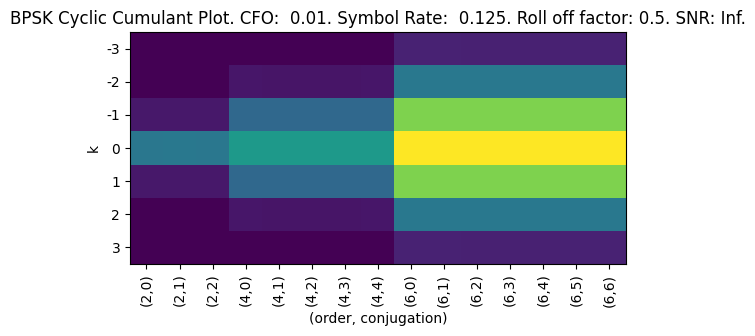

In [34]:
bpsk_cc = calculate_cyclic_cumulant_up_to_6(qpsk_cfo, symbol_rate, BPSK_signal_with_offset)
bpsk_cc_warped = np.zeros(bpsk_cc.shape, dtype="float")
bpsk_cc_warped[:, :3] = np.abs(bpsk_cc[:, :3])
bpsk_cc_warped[:, 3:8] = np.abs(bpsk_cc[:, 3:8])**(1/2)
bpsk_cc_warped[:, 8:] = np.abs(bpsk_cc[:, 8:])**(1/3)

order_and_conjugation = ["(2,0)", "(2,1)", "(2,2)", "(4,0)", "(4,1)", "(4,2)", "(4,3)", "(4,4)", "(6,0)", "(6,1)", "(6,2)", "(6,3)", "(6,4)", "(6,5)", "(6,6)"]

plt.imshow(bpsk_cc_warped)
plt.xticks(range(15), labels=order_and_conjugation, rotation="vertical")
plt.yticks(range(7), labels=range(-3, 4))
plt.ylabel("k")
plt.xlabel("(order, conjugation)")
plt.title(f"BPSK Cyclic Cumulant Plot. CFO: {bpsk_cfo: .2f}. Symbol Rate: {symbol_rate: .3f}. Roll off factor: {beta}. SNR: Inf.")
plt.show()

We can also use log10 to really bring up the smaller magnitudes but I will use the one above because it looks better.

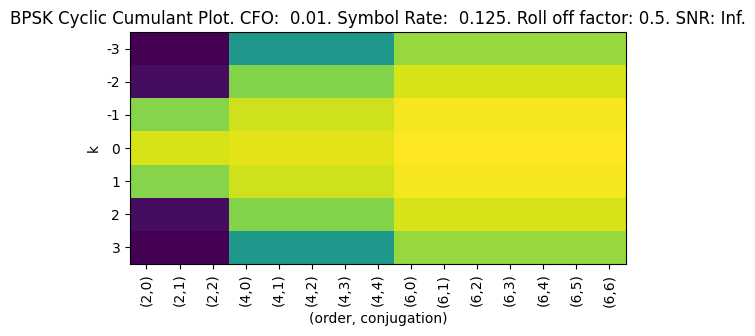

In [40]:
plt.imshow(np.log10(bpsk_cc_warped))
plt.xticks(range(15), labels=order_and_conjugation, rotation="vertical")
plt.yticks(range(7), labels=range(-3, 4))
plt.ylabel("k")
plt.xlabel("(order, conjugation)")
plt.title(f"BPSK Cyclic Cumulant Plot. CFO: {bpsk_cfo: .2f}. Symbol Rate: {symbol_rate: .3f}. Roll off factor: {beta}. SNR: Inf.")
plt.show()

Here are the cyclic cumulant plots for the 4 types of modulation we generated at the start.

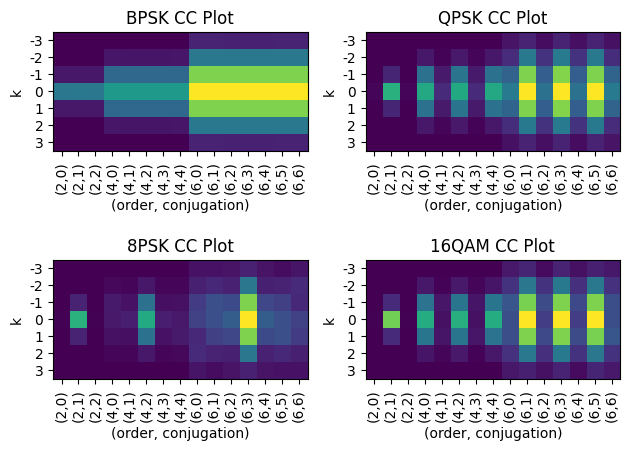

In [47]:
qpsk_cc = calculate_cyclic_cumulant_up_to_6(qpsk_cfo, symbol_rate, QPSK_signal_with_offset)

qpsk_cc_warped = np.zeros(qpsk_cc.shape, dtype="float")
qpsk_cc_warped[:, :3] = np.abs(qpsk_cc[:, :3])
qpsk_cc_warped[:, 3:8] = np.abs(qpsk_cc[:, 3:8])**(1/2)
qpsk_cc_warped[:, 8:] = np.abs(qpsk_cc[:, 8:])**(1/3)

psk_cc = calculate_cyclic_cumulant_up_to_6(psk_cfo, symbol_rate, PSK_signal_with_offset)

psk_cc_warped = np.zeros(psk_cc.shape, dtype="float")
psk_cc_warped[:, :3] = np.abs(psk_cc[:, :3])
psk_cc_warped[:, 3:8] = np.abs(psk_cc[:, 3:8])**(1/2)
psk_cc_warped[:, 8:] = np.abs(psk_cc[:, 8:])**(1/3)

qam_cc = calculate_cyclic_cumulant_up_to_6(qam_cfo, symbol_rate, QAM_signal_with_offset)

qam_cc_warped = np.zeros(qam_cc.shape, dtype="float")
qam_cc_warped[:, :3] = np.abs(qam_cc[:, :3])
qam_cc_warped[:, 3:8] = np.abs(qam_cc[:, 3:8])**(1/2)
qam_cc_warped[:, 8:] = np.abs(qam_cc[:, 8:])**(1/3)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(bpsk_cc_warped)
ax1.set_title("BPSK CC Plot")
ax1.set_ylabel('k') 
ax1.set_xlabel('(order, conjugation)')
ax1.set_xticks(range(15), labels=order_and_conjugation, rotation="vertical")
ax1.set_yticks(range(7), labels=range(-3, 4))

ax2.imshow(qpsk_cc_warped)
ax2.set_title("QPSK CC Plot")
ax2.set_ylabel('k') 
ax2.set_xlabel('(order, conjugation)')
ax2.set_xticks(range(15), labels=order_and_conjugation, rotation="vertical")
ax2.set_yticks(range(7), labels=range(-3, 4))         

ax3.imshow(psk_cc_warped)
ax3.set_title("8PSK CC Plot")
ax3.set_ylabel('k') 
ax3.set_xlabel('(order, conjugation)')
ax3.set_xticks(range(15), labels=order_and_conjugation, rotation="vertical")
ax3.set_yticks(range(7), labels=range(-3, 4))

ax4.imshow(qam_cc_warped)
ax4.set_title("16QAM CC Plot")
ax4.set_ylabel('k') 
ax4.set_xlabel('(order, conjugation)')
ax4.set_xticks(range(15), labels=order_and_conjugation, rotation="vertical")
ax4.set_yticks(range(7), labels=range(-3, 4))         
fig.tight_layout()

# plt.savefig("cc_plot.png", bbox_inches='tight')


## Final Note

Hey, we have made it to the end! I hope everything wasn't too confusing. Don't worry if you don't really understand it at first. I took me one semester of uni to understand and come up with this method of calculating cyclic cumulant. Well, what is it all for you may ask. This is useful for blind modulation recognition: An decades-old but active field of research that is still ongoing.

Here is me using cyclic cumulant estimates to classify modulation types in CSPB.ML.2018R2 dataset. The modulation types are:
  1. BPSK
  2. QPSK
  3. 8PSK
  4. DQPSK
  5. MSK
  6. 16QAM
  7. 64QAM
  8. 256QAM

<img src="cyclic_cumulant_zeroed.png" width="1000" height="500">
<img src="confusion_matrix.png" width="500" height="500">

Well, that is all. I hope you find the notebook helpful. 